# Using a WGAN to Generate Images from Noise

In my [previous notebook](lesson7-superres-gan-my-reimplementation.ipynb) I pre-trained generator and discriminator networks and then used them to create a generative adversarial network that learned how to improve the quality and clarity of blurry images (super resolution).

Now, I will build and train a [Wasserstein-GAN](https://arxiv.org/pdf/1701.07875.pdf) to create pictures of bedrooms from scratch. One big difference between this task and the previous super resolution task is that this WGAN will take inputs containing random noise and convert them into images that look like a typical (possibly slightly upscale) home's bedroom. You can think of the noisy input as being similar to a screenshot of a TV screen that's displaying nothing but static.

The motivation behind the invention of the Wasserstein-GAN was to find a way to make it so that GANs could be more reliably trained to convergence. Specifically, it's a method for creating a trainable GAN without having to worry about carefully monitoring the balance between training the generator and discriminator.

While with a traditional GAN you train the discriminator for as many iterations as it takes until its loss drops below a designated threshold, with WGANs you train the discriminator for a specified number of iterations, then train the generator for one iteration, and repeat this cycle until convergence occurs.

What makes this possible is that we use the [Wasserstein (or Earth-Mover) distance](https://en.wikipedia.org/wiki/Wasserstein_metric) when calculating the gradients of the discriminator's loss. It's simply a method for comparing the probability distributions of two variables, when one variable is derived from the other via *very small* perturbations. 

As the generator improves, we expect that the generated images (of bedrooms in our case) will gradually become nearly indistinguishable from the real images of bedrooms used in the training imageset. It makes intuitive sense that a better way to calculate the loss of the discriminator is to use a function, such as the Wasserstein, that has been tuned to detect small differences. 

A nice side-effect of using this approach, is that the function describing Wasserstein distance is continuous and therefore able to provide a usable gradient at any point. This *is not* the case with the loss surface ([Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence)) from which gradients are calculated in normal GANs.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *
from fastai.vision.gan import *

In [4]:
# Get nicer looking graphs for retina displays
%config InlineBackend.figure_format = 'retina'

## Getting the Dataset: LSUN bedroom data

We'll use the bedroom images that are part of the [LSUN Dataset](http://lsun.cs.princeton.edu/2017/), which contains images of various kinds of large scenes, such as classrooms, restaurants, bridges, etc.

In [5]:
path = untar_data(URLs.LSUN_BEDROOMS)

## Preparing the Data for Training

The fastai library makes it easy to prepare an imageset to be used to train a GAN. The `noise_sz` parameter is used to specify how *"noisy"* (how much static) we want the generator's input images to contain. 

`no_split()` indicates that we won't set aside a validation set. This makes sense for GANs, since our goal is to have a generator that creates brand new images that will fool a discriminator into thinking they are genuine. There is no need to set aside a validation set to gauge performance -- the quality and *real-ness* of the generated images is all we care about.

It's imperative that we set `tfm_y=True` and apply normalization to only the y's and not the x's (`do_y=True`, and `do_x=False`). Why? Because it's the y values, or the targets (genuine images of bedrooms), that we use to help train our discriminator to distinguish real images from the generator's fakes. It's also these targets that are used to teach a generator how to get better at creating fakes.

In [6]:
def get_data(bs, size):
    return (GANItemList.from_folder(path, noise_sz=100)
            .no_split()
            .label_from_func(noop)
            .transform(tfms=[[crop_pad(size=size, row_pct=(0,1))], []], size=size, tfm_y=True)
            .databunch(bs=bs)
            .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

In [7]:
bs = 64
size = 64

In [8]:
data = get_data(bs, size)

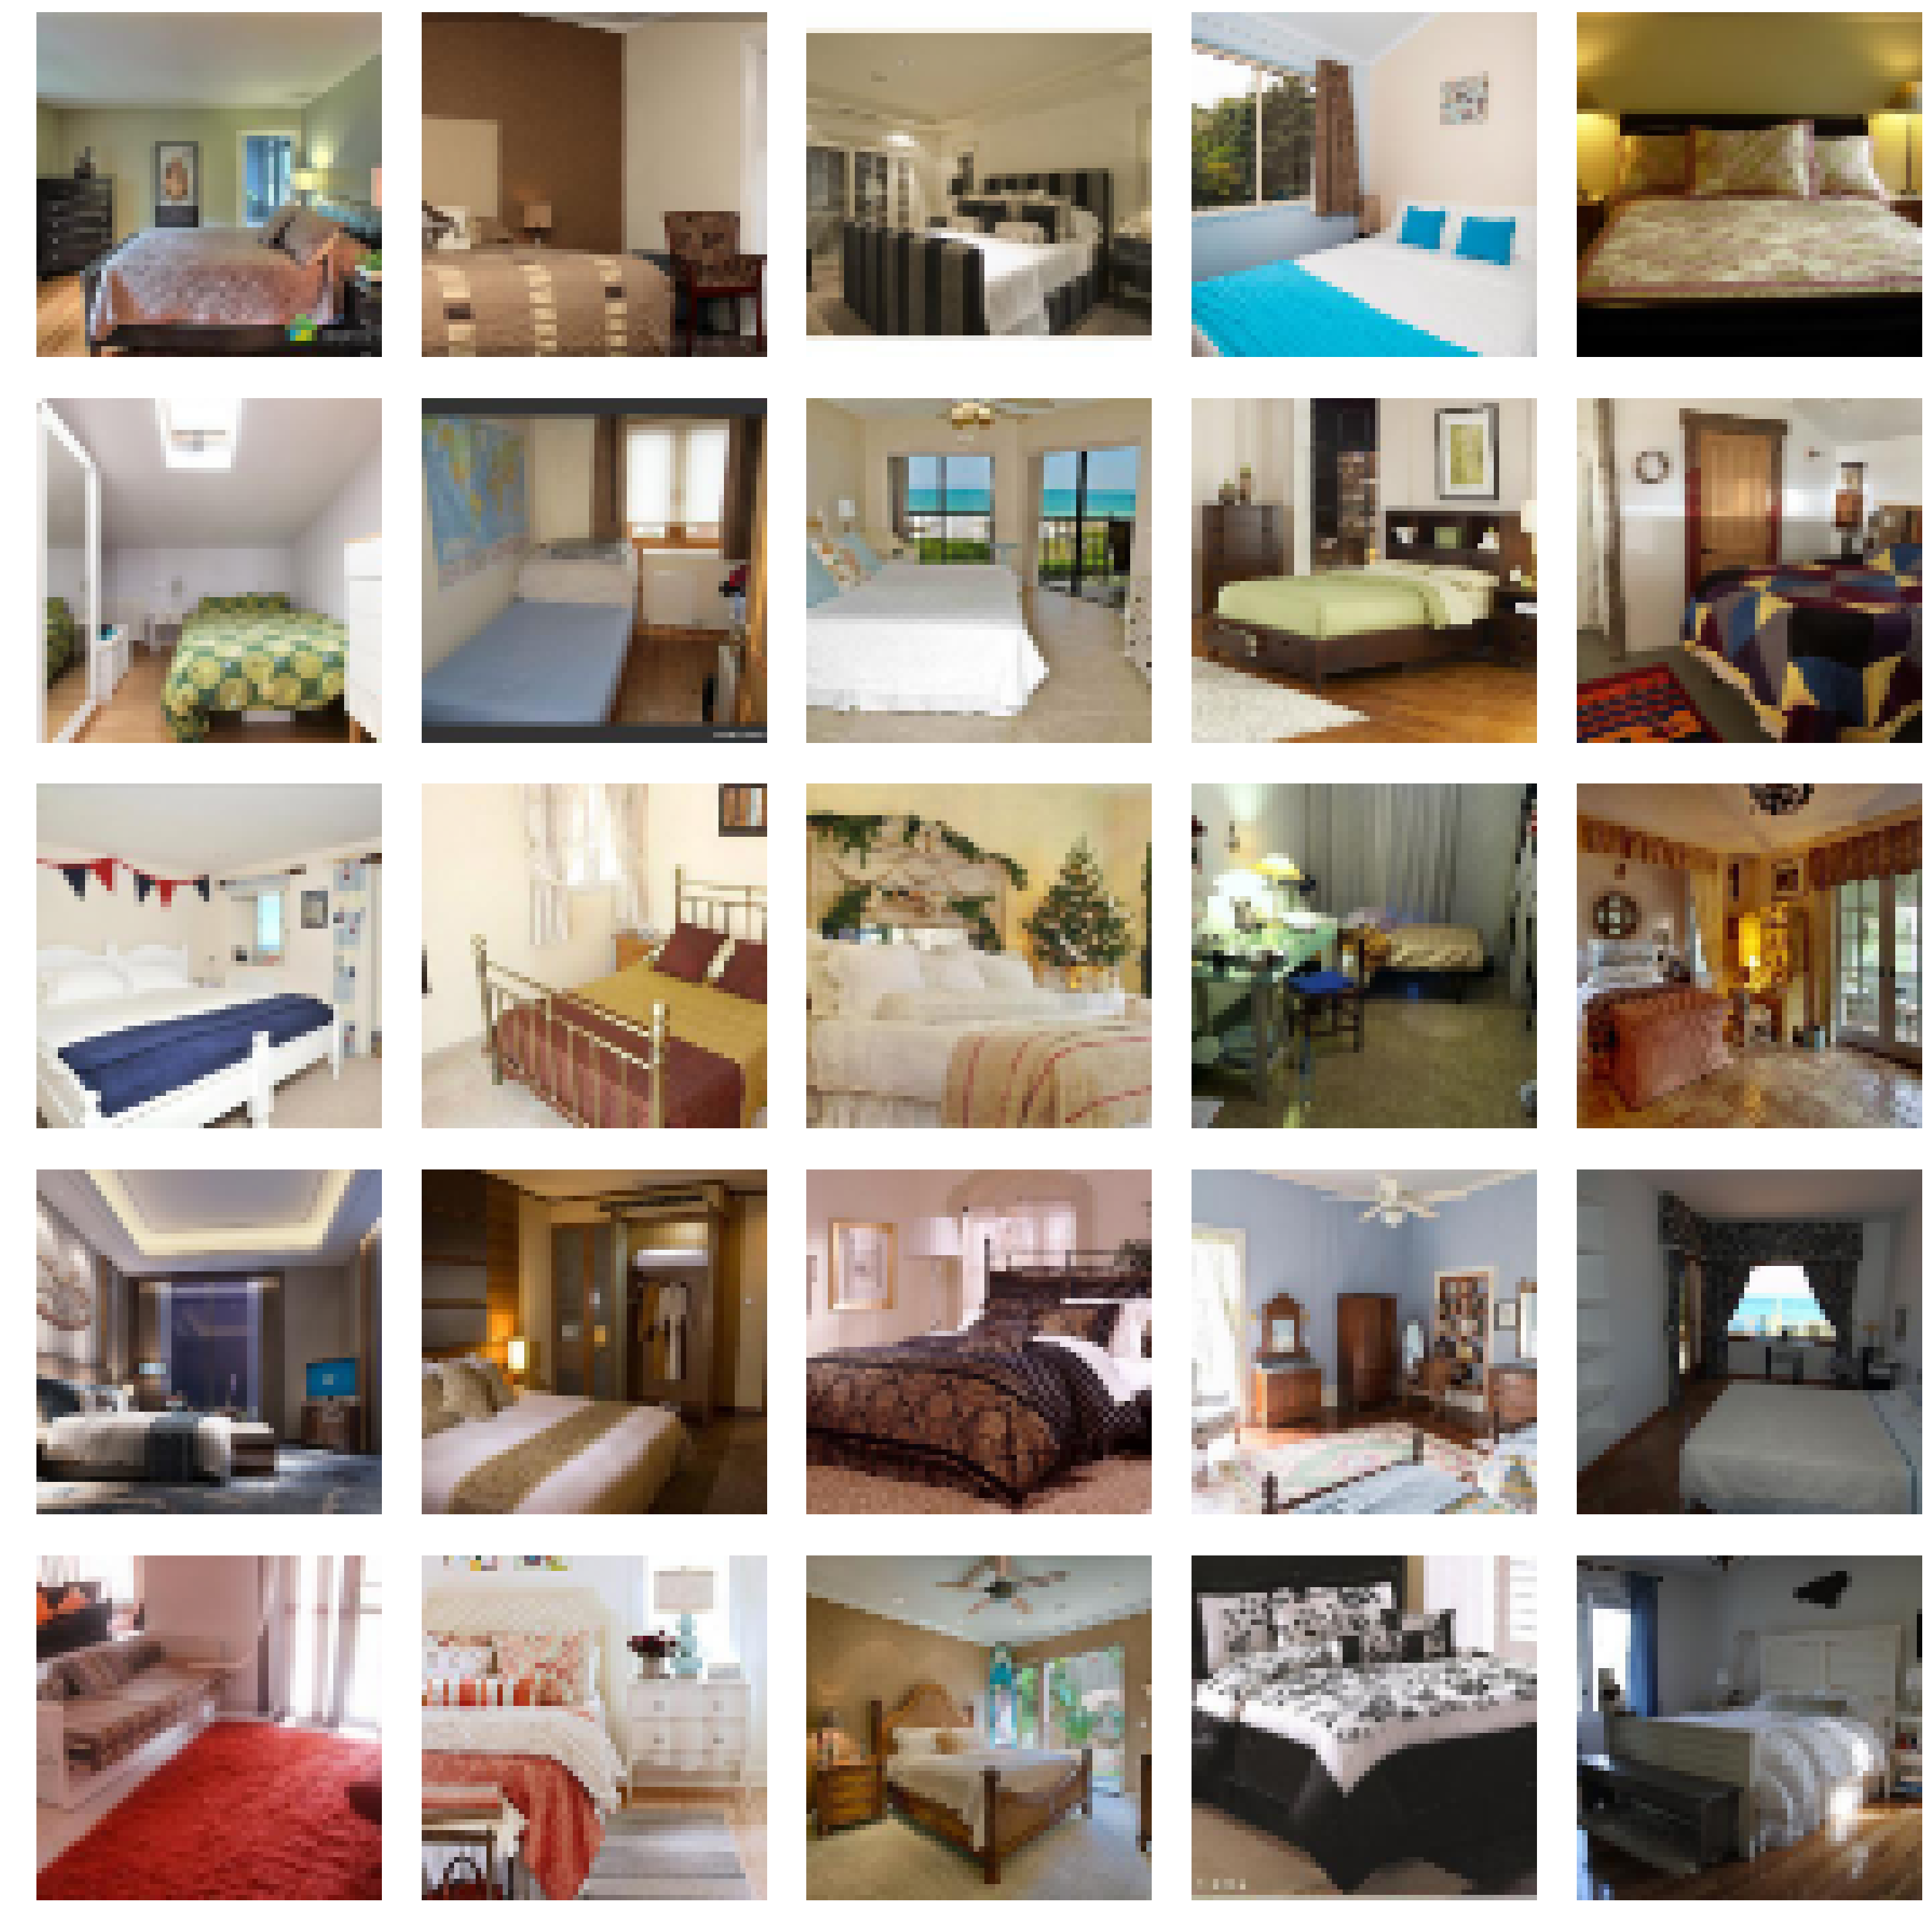

In [9]:
data.show_batch(rows=5)

## Creating and Training the WGAN Model

In [10]:
generator = basic_generator(in_size=size, n_channels=3, n_extra_layers=1)
critic = basic_critic(in_size=size, n_channels=3, n_extra_layers=1)

In [15]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

epoch,train_loss,gen_loss,disc_loss
1,-0.757439,0.529914,-1.016989
2,-0.664457,0.507935,-0.891073
3,-0.547704,0.411218,-0.748138
4,-0.560849,0.427517,-0.767889
5,-0.519979,0.378854,-0.692785
6,-0.479745,0.344860,-0.651849
7,-0.439217,0.297222,-0.587063
8,-0.401057,0.282398,-0.534313
9,-0.353379,0.248647,-0.484620
10,-0.353777,0.217475,-0.467080


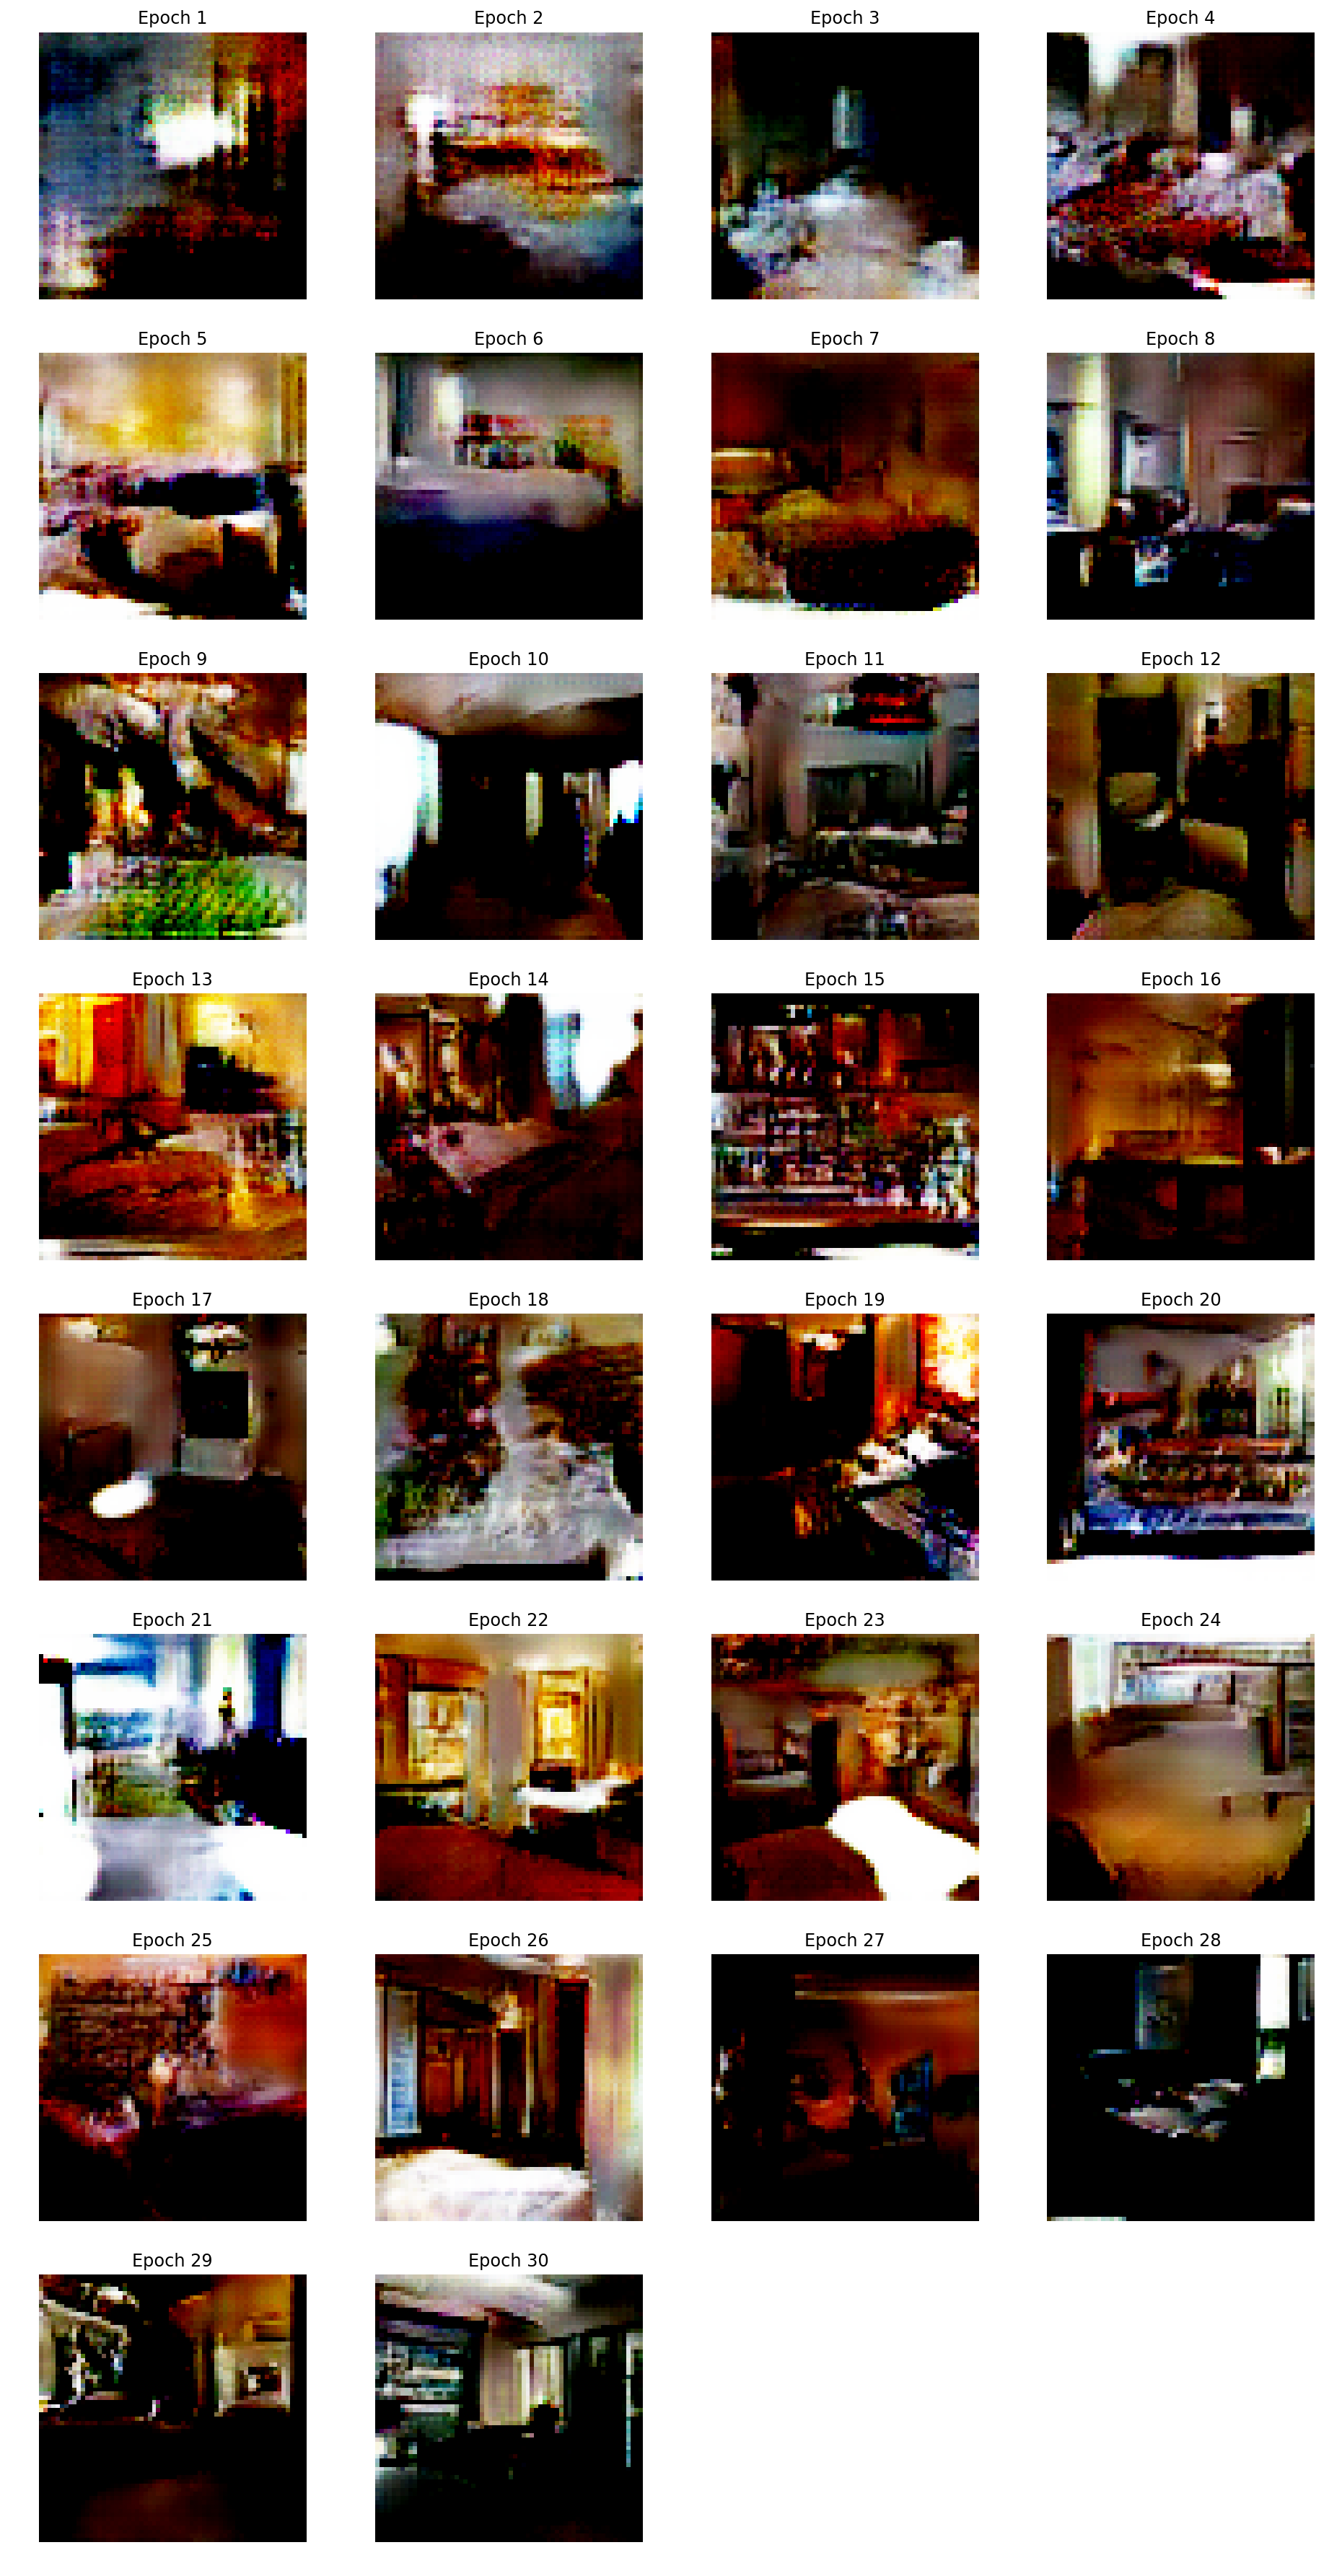

In [16]:
learn.fit(30, 2e-4)

In [17]:
learn.save('wgan')

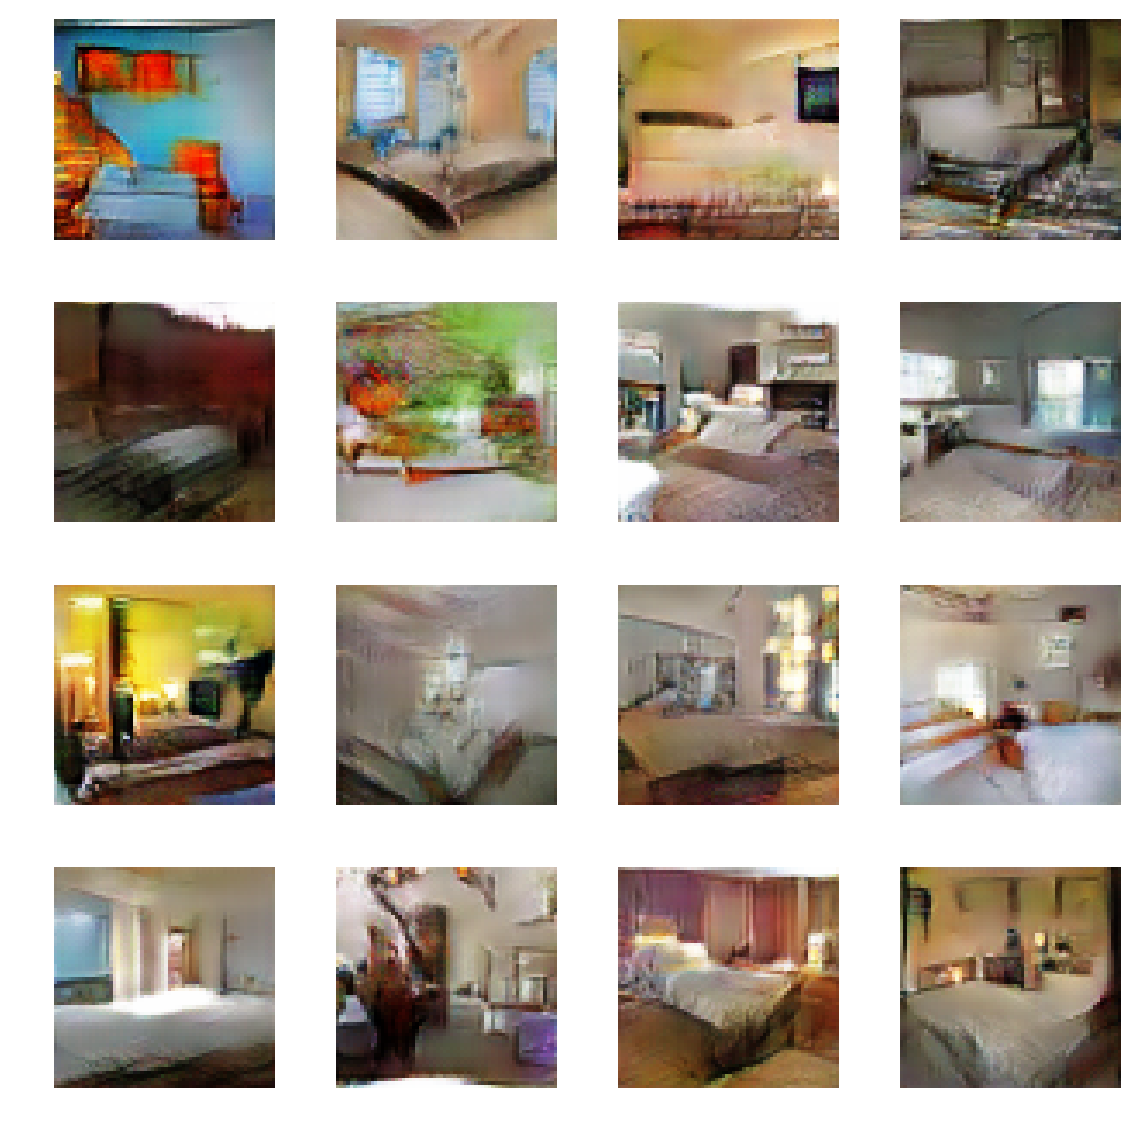

In [20]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(8,8))

The above sample contains some of the bedroom images that our generator learned to create. Quality varies, but around half of the images, were they at a higher resolution, would likely fool even me into believing that they were real bedrooms in real houses.

I kept the image quality at 64 px in order to train the GAN in a reasonable amount of time (still took over three hours on my GPU). If I had gradually upped the target image quality through progressive resizing, I imagine that this WGAN would eventually be able to create high res images that would quite convincingly appear to depict real bedrooms.